In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from Utils.dataset import PreloadedDataset
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from sklearn.metrics import accuracy_score

from Deep_Learning.Experimental.Forward_Forward.nn import FFLayer, FFNet, log_loss
from Deep_Learning.Experimental.Forward_Forward.gen_neg_data import MakeNegativeSample
from Deep_Learning.Experimental.Forward_Forward.train import train_unsup_backward, unsupervised

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
# device = torch.device('cpu')
device

device(type='cuda')

  0%|          | 0/48000 [00:00<?, ?it/s]

Loaded MNIST with 48000 samples


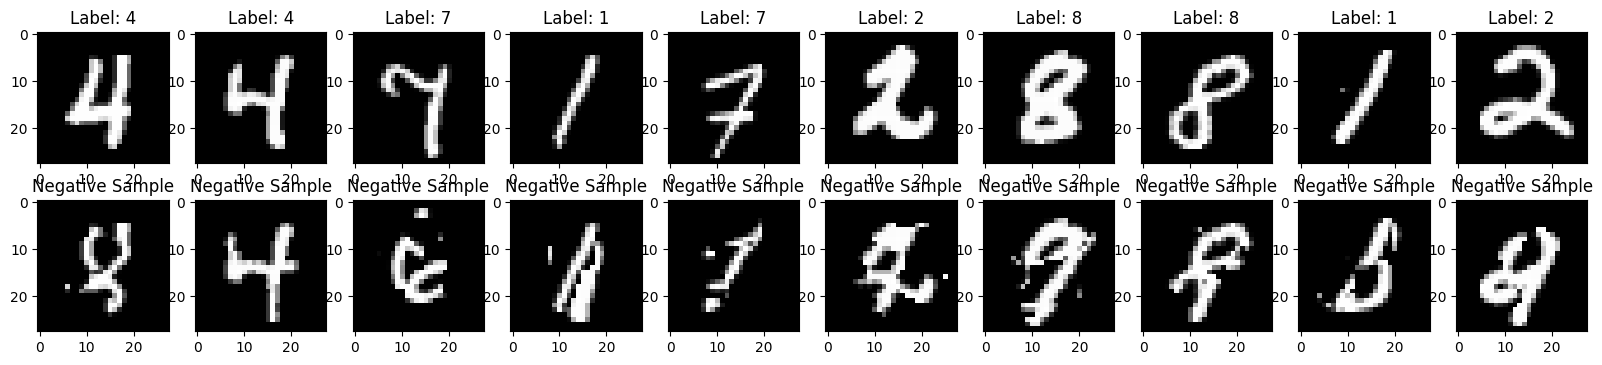

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

raw_dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transform, download=True)
# subset_size = 10000
# raw_dataset = torch.utils.data.Subset(raw_dataset, range(subset_size))

VAL_RATIO = 0.2
n_val = int(len(raw_dataset) * VAL_RATIO)
n_train = len(raw_dataset) - n_val
train_dataset, val_dataset = torch.utils.data.random_split(raw_dataset, [n_train, n_val])

pos_dataset = PreloadedDataset.from_dataset(train_dataset, None, device)
neg_dataset = PreloadedDataset.from_dataset(pos_dataset, MakeNegativeSample(pos_dataset), device)
val_pos_dataset = PreloadedDataset.from_dataset(val_dataset, transforms.ToTensor(), device)
val_neg_dataset = PreloadedDataset.from_dataset(val_pos_dataset, MakeNegativeSample(val_pos_dataset), device)

print(f'Loaded MNIST with {len(pos_dataset)} samples')
# show first samples
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axs[0,i].imshow(pos_dataset[i][0].cpu().permute(1, 2, 0), cmap='gray')
    axs[0,i].set_title(f"Label: {pos_dataset[i][1]}")
    # axs[1,i].imshow(np.squeeze(neg_dataset[i][0].cpu().numpy()), cmap='gray')
    axs[1,i].imshow(neg_dataset[i][0].cpu().permute(1, 2, 0), cmap='gray')
    axs[1,i].set_title(f"Negative Sample")
plt.show()

# Train Feedforward Networks Using Forward-Forward

In [4]:
torch.manual_seed(42)

# Hyperparameters
# reg_coeff = 0.1

# Parameter Initialisation
sizes = [784, 2000, 2000, 2000, 2000]
ffnet = FFNet(sizes, bias=True, threshold=2, device=torch.device(device))
# optimiser = torch.optim.Adam(ffnet.parameters(), lr=lr)
# optimiser = torch.optim.AdamW(ffnet.parameters(), lr=lr, weight_decay=reg_coeff)
layer_losses = None
layer_val_losses = None
layer_diff_logits = None
layer_val_diff_logits = None

In [10]:
pos_dataloader = DataLoader(pos_dataset, batch_size=1, shuffle=True)
pos_x = next(iter(pos_dataloader))[0].flatten(start_dim=1)
neg_dataloader = DataLoader(neg_dataset, batch_size=1, shuffle=True)
neg_x = next(iter(neg_dataloader))[0].flatten(start_dim=1)
for i, layer in enumerate(ffnet.layers):
    pos_x = layer(pos_x)
    neg_x = layer(neg_x)
    loss, diff = log_loss(pos_x, neg_x, mode="minimise")
    print(f"Layer {i}: loss - {loss.item():} diff - {diff:}")
    pos_x = F.normalize(pos_x)
    neg_x = F.normalize(neg_x)

Layer 0: loss - 1.0680570602416992 diff - 0.027920842170715332
Layer 1: loss - 1.1268610954284668 diff - 1.5497207641601562e-06
Layer 2: loss - 1.1268599033355713 diff - 7.152557373046875e-07
Layer 3: loss - 1.1268666982650757 diff - 7.62939453125e-06


In [5]:
EPOCHS = [100, 100, 100, 100]
BATCH_SIZE = 5000
LR = 0.003
MODE = "minimise"

layer_losses, layer_val_losses, layer_diff_logits, layer_val_diff_logits = unsupervised(
    ffnet,
    LR,
    pos_dataset,
    neg_dataset,
    val_pos_dataset,
    val_neg_dataset,
    EPOCHS,
    BATCH_SIZE,
    MODE,
    layer_losses,
    layer_val_losses,
    layer_diff_logits,
    layer_val_diff_logits
)

In [10]:
len(layer_losses)

4

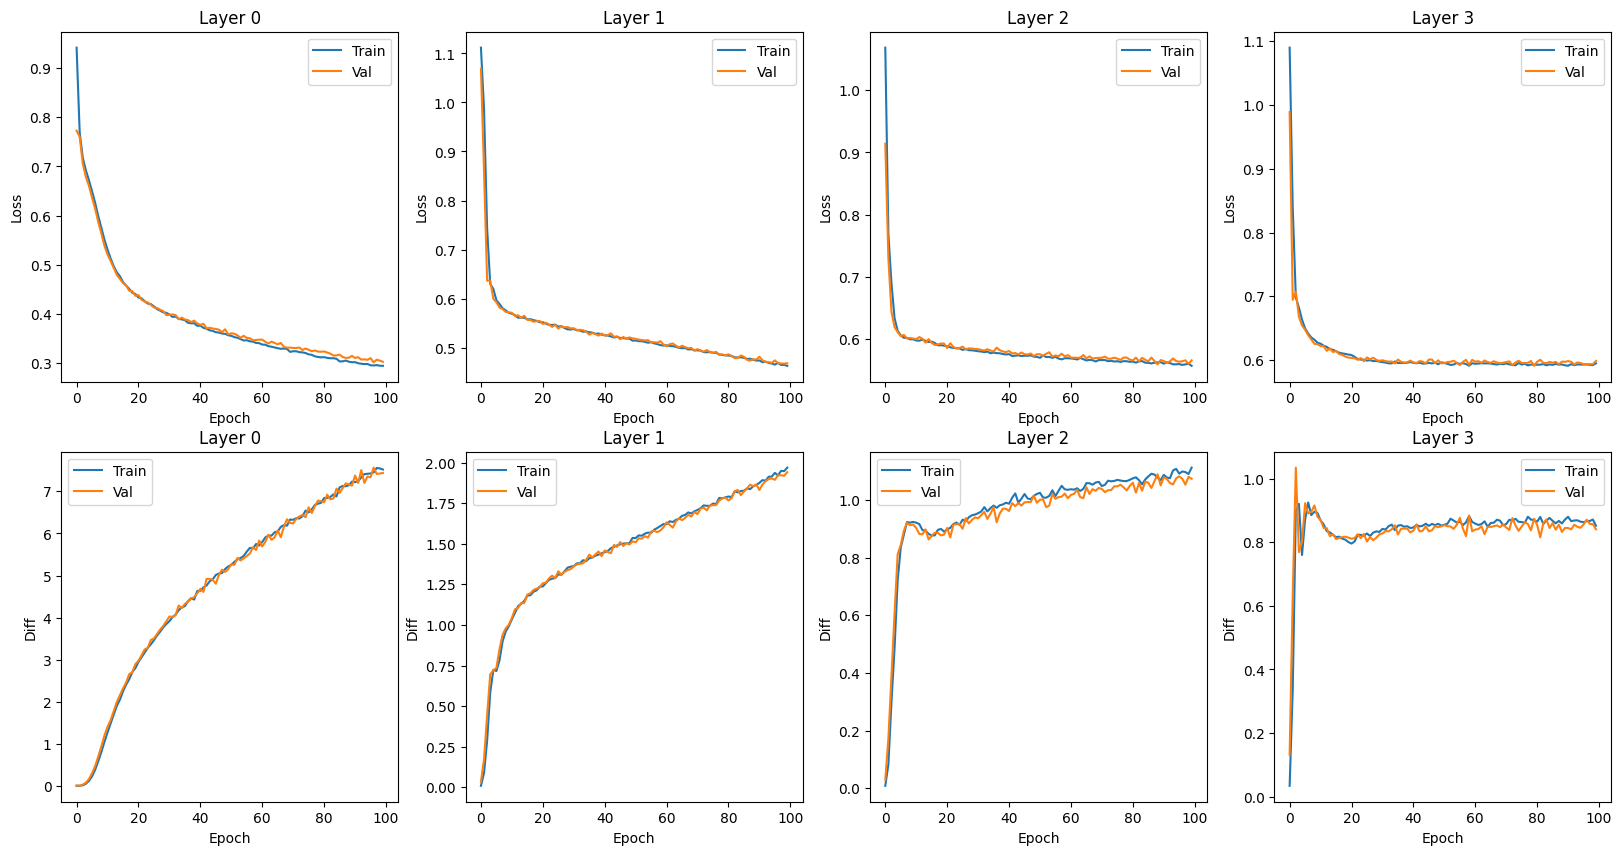

In [6]:
fig, axs = plt.subplots(2, len(ffnet.layers), figsize=(20, 10))
for i, layer in enumerate(ffnet.layers):
    axs[0,i].plot(layer_losses[i], label="Train")
    axs[0,i].plot(layer_val_losses[i], label="Val")
    axs[0,i].set_title(f"Layer {i}")
    axs[0,i].set_xlabel("Epoch")
    axs[0,i].set_ylabel("Loss")
    axs[0,i].legend()
    axs[1,i].plot(layer_diff_logits[i], label="Train")
    axs[1,i].plot(layer_val_diff_logits[i], label="Val")
    axs[1,i].set_title(f"Layer {i}")
    axs[1,i].set_xlabel("Epoch")
    axs[1,i].set_ylabel("Diff")
    axs[1,i].legend()

# Train Classifier on network activations

In [7]:
def train_classifier(
    ffnet,
    classifier, 
    train_dataset, 
    val_dataset, 
    epochs, 
    batch_size,
    optimiser, 
    criterion, 
    train_loss=[],
    val_loss=[],
    val_acc=[],
    steps = [],
):
    ffnet.eval()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        classifier.train()
        running_loss = 0.0
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        if epoch > 0:
            loop.set_description(f"Epoch {epoch}")
            loop.set_postfix(train_loss=train_loss[-1], val_loss=val_loss[-1], val_acc=val_acc[-1])
        for i, data in loop:
            x, y = data
            with torch.no_grad():
                x = x.flatten(start_dim=1)
                outs = ffnet(x)

            outs = torch.cat(outs[1:], dim=1)
            optimiser.zero_grad()
            y_pred = classifier(outs)
            loss = criterion(y_pred, y)
            loss.backward()
            optimiser.step()

            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))
        if len(steps) > 0:
            steps.append(steps[-1] + len(train_dataset))
        else:
            steps.append(len(train_dataset))

        classifier.eval()
        running_loss = 0.0
        correct = 0
        for i, data in enumerate(val_loader):
            x, y = data
            with torch.no_grad():
                x = x.flatten(start_dim=1)
                outs = ffnet(x)

            outs = torch.cat(outs[1:], dim=1)
            y_pred = classifier(outs)
            loss = criterion(y_pred, y)
            running_loss += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == y).sum().item()
        val_loss.append(running_loss / len(val_loader))
        val_acc.append(correct / len(val_dataset))

    return train_loss, val_loss, val_acc, steps


In [8]:
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

in_size = [layer.out_features for layer in ffnet.layers]
in_size = sum(in_size[1:])
print(f"Input size: {in_size}")
classifier = Classifier(in_size, 32, 10).to(device)
optimiser = torch.optim.AdamW(classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_loss = []
val_loss = []
val_acc = []
steps = []   

Input size: 6000


In [11]:
EPOCHS = 30
BATCH_SIZE = 256

train_loss, val_loss, val_acc, steps = train_classifier(ffnet, classifier, pos_dataset, val_pos_dataset, EPOCHS, BATCH_SIZE, optimiser, criterion, train_loss, val_loss, val_acc, steps)

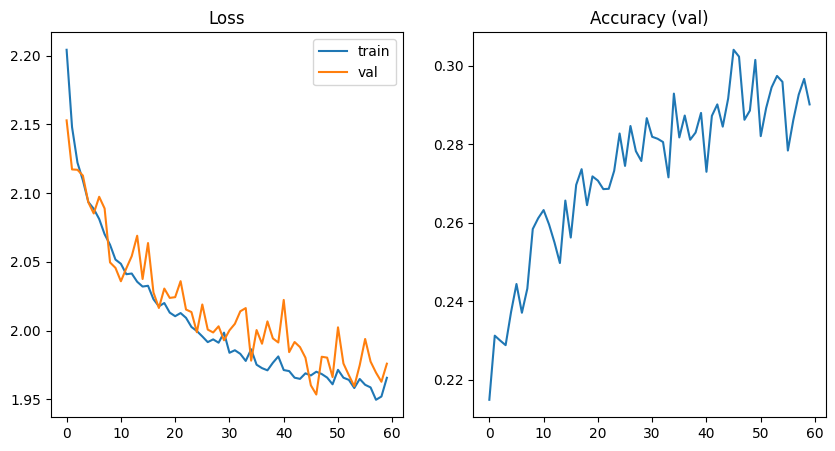

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(train_loss, label='train')
axs[0].plot(val_loss, label='val')
axs[0].legend()
axs[0].set_title('Loss')

axs[1].plot(val_acc)
axs[1].set_title('Accuracy (val)')

plt.show()
